## quick view picture

PIL mode: RGB
PIL mode: L


/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/275598224.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


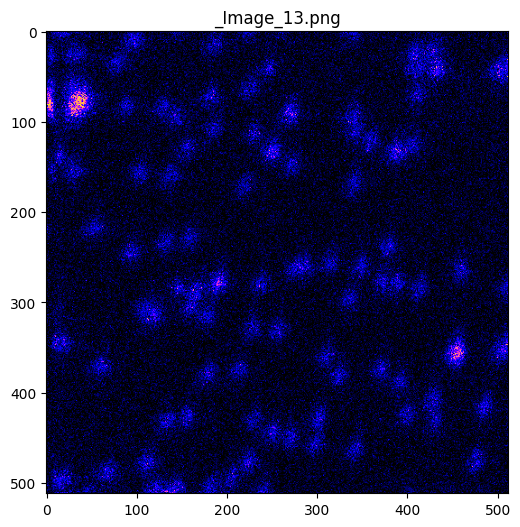

In [1075]:
# open PNG image plot with matplotlib
fileDir = './4_data/trainning/200nm/'
fileName = '_Image_13.png'

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open(fileDir + fileName)
print("PIL mode:", img.mode) # mode 屬性會告訴你色彩模式

img = img.convert('L')  # convert to grayscale
print("PIL mode:", img.mode)
img_array = np.array(img)
fig1, ax = plt.subplots(figsize=(8, 6))
ax.imshow(img_array, cmap='gnuplot2')
ax.set_title(fileName)
fig1.show()

## function view normed picture 

In [1076]:
# norm with sqrt and plot center percent
from astropy.visualization import simple_norm

def plot_picture(data, percent, title: str, **kwargs):
    '''
    plot the fits file data
    img:
    get data by 
    hdu = fits.open('SLT_EPIC210651981.fits')
    data = hdu[0].data

    percent:
    only show middle {percent} percent data
    '''
    norm = simple_norm(data, stretch='sqrt', percent=percent)
    fig, ax = plt.subplots(**kwargs)  # 使用 subplots 來獲取圖形和軸對象
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    fig.colorbar(img, ax=ax)  # 添加色條
    return fig, ax


### testing

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/3025193716.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


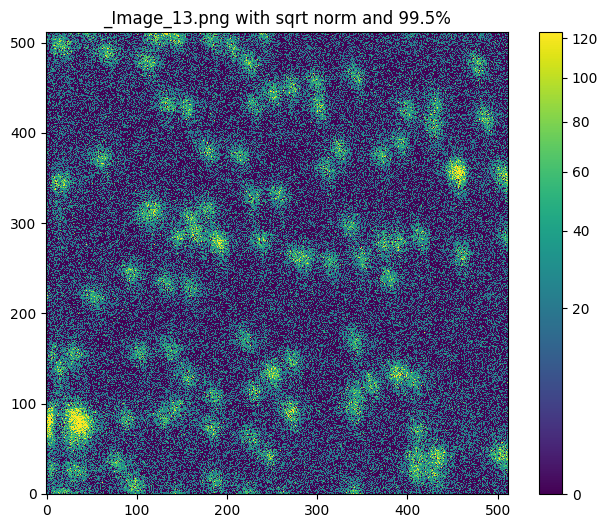

In [1077]:

fig, ax = plot_picture(img_array, percent=99.5, title='Image_12.png', figsize=(8, 6))
ax.set_title(f'{fileName} with sqrt norm and 99.5%')
fig.show()

## background clean

In [1078]:
def kappaSigmaClipping(kappa, iter, img_ori):
    '''
    do Kappa-Sigma Clipping, returm the mask in 2D array,
    True is pixel belong to background
    False is pixel belong to source
    img_ori: original image in 2D array
    kappa: kappa value, kappa * std will classify as source
    iter: iteration times
    '''
    img = img_ori
    mask = img > np.min(img) # create mask
    keep_pixel = img
    for i in range(iter):
        mean = np.mean(keep_pixel)
        std = np.std(keep_pixel)
        
        mask = img < mean + kappa*std
        keep_pixel = img[mask]
    bg_mean = np.mean(img[mask])
    bg_std = np.std(img[mask])
    return mask, bg_mean, bg_std

# bg_mean

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/2684351129.py:8: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 1000 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img_bg[~mask] = 1000  # set source pixel to bg_mean
/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/2684351129.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


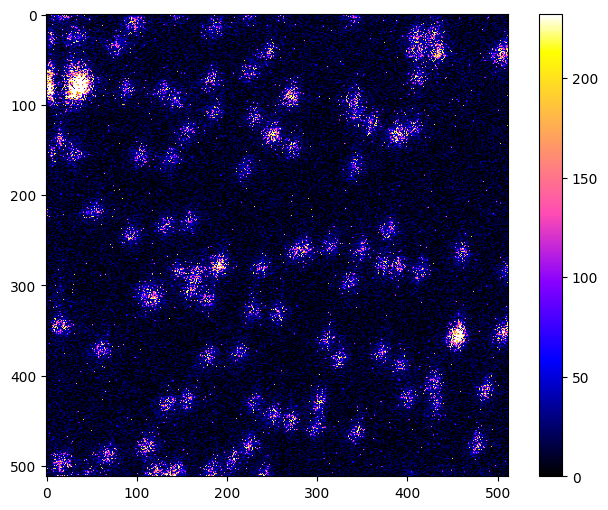

In [1079]:
# viw the region that > bg_mean + kappa*std -> source
# let it be a great value to see it

mask, bg_mean, bg_std = kappaSigmaClipping(3, 20, img_array)
fig, ax = plt.subplots(figsize=(8, 6))

img_bg = np.copy(img_array)
img_bg[~mask] = 1000  # set source pixel to bg_mean
ax.imshow(img_bg, cmap='gnuplot2')
# colorbar
fig.colorbar(ax.imshow(img_bg, cmap='gnuplot2'), ax=ax)
fig.show()


### testing

In [1080]:
mask, bg_mean, bg_std = kappaSigmaClipping(3, 7, img_array)

image_clean_bg = img_array - bg_mean
image_clean_bg[image_clean_bg < 0] = 0

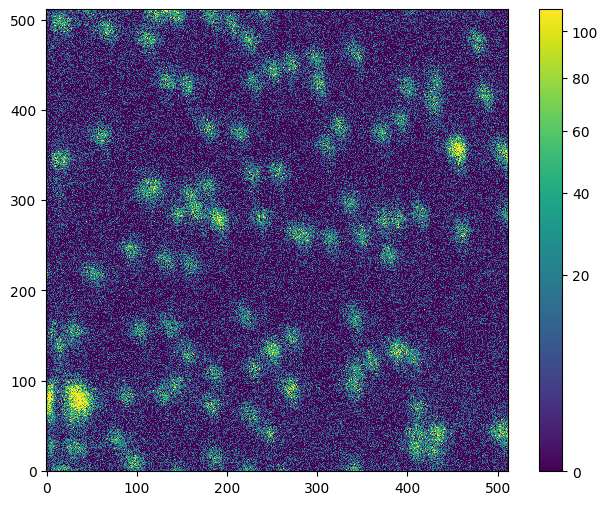

In [1081]:
fig, ax = plot_picture(image_clean_bg, percent=99.5, title='Image_12.png', figsize=(8, 6))

## source detection

In [1082]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats 
import scipy

def find_source(data, sigma=100.0, fwhm=7.0, threshold_times=5.):
    mean, median, std = sigma_clipped_stats(data, sigma=sigma) 
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold_times*std)  
    sources = daofind(data - median)  
    for col in sources.colnames:  
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f'  # for consistent table output
    return sources

## plot source by circle

In [1083]:
from photutils.aperture import CircularAperture

def plot_source(data, sources, **kwargs):
    '''
    return fig, ax
    '''
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    apertures = CircularAperture(positions, r=10.0)
    norm = simple_norm(data, stretch='sqrt', percent=99)

    fig, ax = plt.subplots(**kwargs)  # 使用 subplots 來獲取圖形和軸對象
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    apertures.plot(color='white', lw=2, alpha=0.9, ax=ax)
    fig.colorbar(img, ax=ax)  # 添加色條

    # 返回圖形和軸對象
    return fig, ax

### testing

source number:  42


Text(0.5, 1.0, '_Image_13.png with sources')

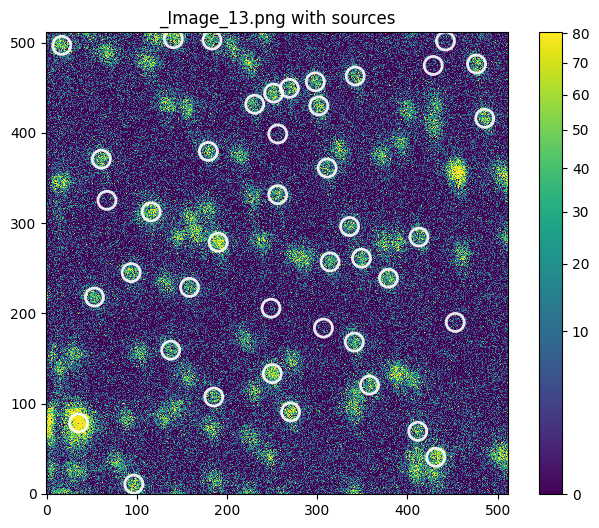

In [1084]:
source = find_source(image_clean_bg, sigma=3.0, fwhm=30.0, threshold_times=5.)
print("source number: ", len(source))
# plot sources
fig_s, ax_s = plot_source(image_clean_bg, source, figsize=(8, 6))
ax_s.set_title(f'{fileName} with sources')

In [1085]:
source

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,96.66,10.72,0.50,-0.30,-0.17,1521,0.00,41.30,27.38,-3.59
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02


## calculate fwhm

In [1086]:
from astropy.modeling import models, fitting

def FWHM(Qtable, data, sub_size_half=6):
    '''
    return fwhm_x_list, fwhm_y_list, mask
    mask is a boolen vector, if star distance to image margin
    smaller then sub_size_half, mask value will be false
    '''
    fwhm_x_list = []
    fwhm_y_list = []
    mask = []
    for i in range(len(Qtable)):
        xc, yc = Qtable['xcentroid'][i], Qtable['ycentroid'][i]  # 你需要替换为你的星星位置

        # 如果需要，选取一个子区域进行拟合
        # 例如，取以 (x, y) 为中心的 12 x 12 像素区域
        x_min, x_max = int(xc - sub_size_half), int(xc + sub_size_half)
        y_min, y_max = int(yc - sub_size_half), int(yc + sub_size_half)
        # print(x_min, x_max, y_min, y_max)
        if x_min < 0 or x_max < 0 or y_min < 0 or y_max < 0:
            fwhm_x_list.append(-1)
            fwhm_y_list.append(-1)
            mask.append(False)
            continue
        mask.append(True)
        sub_data = data[y_min:y_max, x_min:x_max]
        yp, xp = sub_data.shape


        # Generate grid of same size like box to put the fit on
        y, x, = np.mgrid[:yp, :xp]
        # Declare what function you want to fit to your data
        f_init = models.Gaussian2D()
        # Declare what fitting function you want to use
        fit_f = fitting.LevMarLSQFitter()

        # Fit the model to your data (box)
        fitted_g = fit_f(f_init, x, y, sub_data)


        # 计算 FWHM
        fwhm_x = 2.355 * fitted_g.x_stddev.value
        fwhm_y = 2.355 * fitted_g.y_stddev.value

        fwhm_x_list.append(fwhm_x)
        fwhm_y_list.append(fwhm_y)

    return fwhm_x_list, fwhm_y_list, mask

### testing

In [1087]:
x_fwhm, y_fwhm, mask = FWHM(source, image_clean_bg, sub_size_half=6)
source['x_fwhm'] = x_fwhm
source['y_fwhm'] = y_fwhm
source = source[mask]
source

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1,96.66,10.72,0.50,-0.30,-0.17,1521,0.00,41.30,27.38,-3.59,362.90803827974673,11.34711970431122
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65,31.76238438166732,17.96111177101807
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08,19.9752119198433,11.675395780911195
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98,1114.8210456673362,13.982987050790406
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84,16.94938790458062,10.16748874112278
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99,48.97251255228791,13.117643323893976
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03,28.336251792822587,12.05168279831461
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84,14.459163539024555,56.56473754960743
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02,65.23694237455436,14.771420378039137


## plot source elipse

In [1088]:
from photutils.aperture import EllipticalAperture

def plot_source_fwhm_elips(data, sources, **kwargs):
    apertures = []
    for source in sources:
        position = (source['xcentroid'], source['ycentroid'])
        a = source['x_fwhm']  # x軸半徑
        b = source['y_fwhm']  # y軸半徑
        theta = 0  # 橢圓角度（如有可用 source['theta']）
        aperture = EllipticalAperture(position, a=a, b=b, theta=theta)
        apertures.append(aperture)

    norm = simple_norm(data, stretch='sqrt', percent=99)
    fig, ax = plt.subplots(**kwargs)
    img = ax.imshow(data, cmap='viridis', origin='lower', norm=norm, interpolation='nearest')
    fig.colorbar(img, ax=ax)
    for aperture in apertures:
        aperture.plot(color='white', lw=1.5, alpha=0.9, ax=ax)
    return fig, ax


### testing

Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

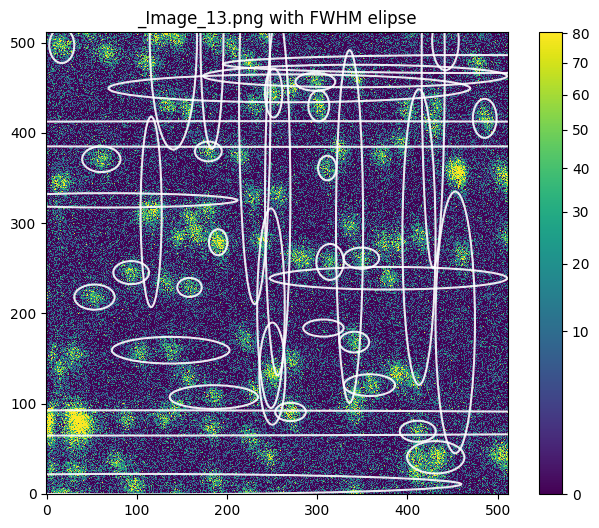

In [1089]:
fig, ax = plot_source_fwhm_elips(image_clean_bg, source, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')



In [1090]:
source

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
1,96.66,10.72,0.50,-0.30,-0.17,1521,0.00,41.30,27.38,-3.59,362.90803827974673,11.34711970431122
2,431.30,40.47,0.31,0.40,0.15,1521,0.00,41.30,28.76,-3.65,31.76238438166732,17.96111177101807
3,411.41,69.30,0.33,-0.06,0.31,1521,0.00,23.30,17.10,-3.08,19.9752119198433,11.675395780911195
4,35.45,78.55,0.52,-0.35,0.36,1521,0.00,169.30,98.21,-4.98,1114.8210456673362,13.982987050790406
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84,16.94938790458062,10.16748874112278
6,185.32,107.25,0.98,-0.29,0.22,1521,0.00,41.30,15.72,-2.99,48.97251255228791,13.117643323893976
7,357.90,120.45,0.27,0.39,0.20,1521,0.00,23.30,16.24,-3.03,28.336251792822587,12.05168279831461
8,250.20,133.23,0.59,0.27,0.17,1521,0.00,59.30,34.24,-3.84,14.459163539024555,56.56473754960743
9,137.58,159.15,0.37,-0.34,0.11,1521,0.00,23.30,16.21,-3.02,65.23694237455436,14.771420378039137


## plot FWHM x y distribution

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/1015418424.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


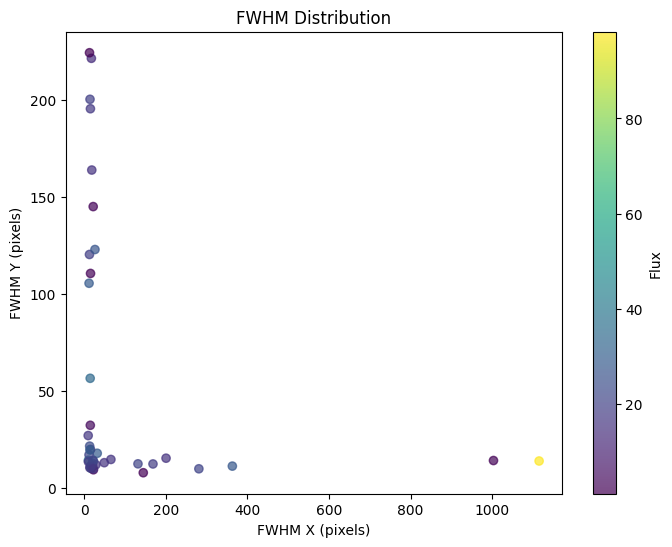

In [1091]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(source['x_fwhm'], source['y_fwhm'], c=source['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

In [1092]:
# ignore fwhm > 40
threshold = 20
source = source[(source['x_fwhm'] < threshold) & (source['y_fwhm'] < threshold)]
len(source)

12

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/1015418424.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


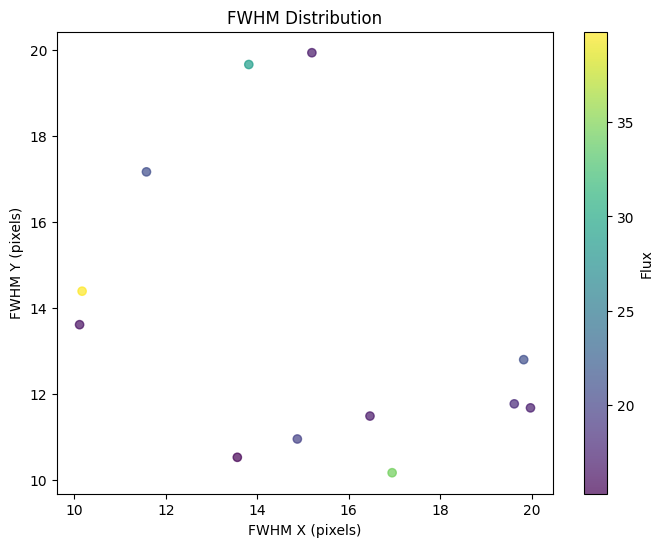

In [1093]:
# plot the distribution of fwhm x y size dot plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(source['x_fwhm'], source['y_fwhm'], c=source['flux'], cmap='viridis', alpha=0.7)
fig.colorbar(sc, label='Flux')
ax.set_xlabel('FWHM X (pixels)')
ax.set_ylabel('FWHM Y (pixels)')
ax.set_title('FWHM Distribution')
fig.show()

Text(0.5, 1.0, '_Image_13.png with FWHM elipse')

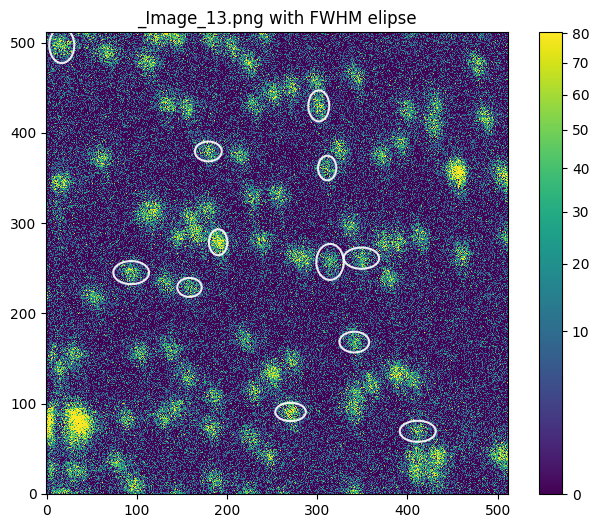

In [1094]:
fig, ax = plot_source_fwhm_elips(image_clean_bg, source, figsize=(8, 6))
ax.set_title(f'{fileName} with FWHM elipse')

In [1095]:
source[1]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,x_fwhm,y_fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
5,270.42,90.75,0.61,-0.10,0.29,1521,0.00,59.30,34.38,-3.84,16.94938790458062,10.16748874112278


## from source center,  draw a rectangle, fit gaussian. draw a line for x +- 2FWHMx, average y +- factor * FWHMy 

In [1096]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

factor = 1 # factor for FWHM_y in plot_x_cut_gaussian

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset


def fit_gaussian(image, sources, sourceID, factor=1):
    source = sources[sourceID]
    x0 = source['xcentroid']
    y0 = source['ycentroid']
    y_half_range = factor * source['y_fwhm']
    
    # 選擇 Y 範圍的像素索引
    y_min = int(max(0, y0 - y_half_range))
    y_max = int(min(image.shape[0], y0 + y_half_range + 1))
    # X 軸範圍 ± 2×FWHM
    x_min = int(max(0, x0 - 2*source['x_fwhm']))
    x_max = int(min(image.shape[1], x0 + 2*source['x_fwhm'] + 1))
    # 取出該範圍的截面
    cut_data = image[y_min:y_max, x_min:x_max]
    
    # Y 平均 → 一維強度分佈
    intensity_profile = np.mean(cut_data, axis=0)
    

    x_range = np.arange(x_min, x_max)
    x_rel_range = x_range - x0
    
    # Gaussian 擬合
    p0 = [np.max(intensity_profile)-np.min(intensity_profile), 0, source['x_fwhm']/2.355, np.min(intensity_profile)]
    parm, _ = curve_fit(gaussian, x_rel_range, intensity_profile, p0=p0)
    
    return parm, x_rel_range, intensity_profile, x0, y_half_range



In [1097]:
def fit_gaussian2(image, sources, sourceID, axis, factor=1):
    '''
    try to let it can fit x and y
    axis = x or y
    '''
    x_label = ('xcentriod', 'x_fwhm')
    y_label = ('ycentroid', 'y_fwhm')

    if axis == 'x':
        horizontal_label = x_label
        vertical_label = y_label
    if axis == 'y':
        horizontal_label = y_label
        vertical_label = x_label
    else:
        print("axis should br x or y")

    source = sources[sourceID]
    x0 = source[horizontal_label[0]]
    y0 = source[vertical_label[0]]
    y_half_range = factor * source[vertical_label[1]]
    
    # 選擇 Y 範圍的像素索引
    y_min = int(max(0, y0 - y_half_range))
    y_max = int(min(image.shape[0], y0 + y_half_range + 1))
    # X 軸範圍 ± 2×FWHM
    x_min = int(max(0, x0 - 2*source[horizontal_label[1]]))
    x_max = int(min(image.shape[1], x0 + 2*source[horizontal_label[1]] + 1))
    # 取出該範圍的截面
    cut_data = image[y_min:y_max, x_min:x_max]
    
    # Y 平均 → 一維強度分佈
    intensity_profile = np.mean(cut_data, axis=0)
    

    x_range = np.arange(x_min, x_max)
    x_rel_range = x_range - x0
    
    # Gaussian 擬合
    p0 = [np.max(intensity_profile)-np.min(intensity_profile), 0, source[horizontal_label[1]]/2.355, np.min(intensity_profile)]
    parm, _ = curve_fit(gaussian, x_rel_range, intensity_profile, p0=p0)
    
    return parm, x_rel_range, intensity_profile, x0, y_half_range

In [ ]:

factor = 1 # factor for FWHM_y in plot_x_cut_gaussian

def gaussian(x, amp, mu, sigma, offset):
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2)) + offset

def plot_x_cut_gaussian(image, sources, sourceID, factor=1, ax=None):
    '''
    plot the x cut +- 2 FWHMx, avg(+- factor * FWHMy) of the source and fit with gaussian
    '''
    if ax is None:
        figsize=(6,4)
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure # 表示外面傳進來的 ax，要交給外面管理

    source = sources[sourceID]
    parm, x_rel, intensity_profile, x0, y_half_range = fit_gaussian(image, sources, sourceID, factor=factor)

    # 繪圖
    ax.plot(x_rel, intensity_profile, 'g.', label='Data')
    ax.plot(x_rel, gaussian(x_rel, *parm), 'k--', label='Gaussian fit')
    
    # 從擬合參數取出 mu, sigma
    amp, mu, sigma, offset = parm # mu 是中心, sigma 是標準差
    fwhm = 2.355 * sigma

    # 畫出中心線
    ax.axvline(mu, color='gray', linestyle='-', label='Fit center')

    # --- FWHM 標示區塊 ---
    amp, mu, sigma, offset = parm
    fwhm = 2.355 * sigma
    half_max = offset + amp / 2

    # 畫灰底矩形 (標示 FWHM 區域)
    ax.axvspan(mu - fwhm/2, mu + fwhm/2, 
               ymin=0,
               color='gray', alpha=0.2)
    # 雙箭頭顯示 FWHM
    ax.annotate(
        '', 
        xy=(mu + fwhm/2, half_max), 
        xytext=(mu - fwhm/2, half_max),
        arrowprops=dict(arrowstyle='<->', color='b', lw=1.5)
    )
    # 在箭頭下方加文字標籤
    ax.text(mu, half_max*0.7, f"FWHM = {fwhm:.2f}", 
            color='b', ha='center', va='bottom', fontsize=10)




    # 標示 Y 標準差
    # ax.errorbar(x_rel, intensity_profile, yerr=intensity_std, fmt='none',ecolor='g', label='Data ± 1σ', alpha=0.3)

    ax.set_xlabel('X distance from center [pixels]')
    ax.set_ylabel('Intensity')
    ax.set_title(
    f"ID:{sourceID} Cut at x = {int(x0)}, y ± {int(source['y_fwhm']*factor)} pixels\n"
    )
    ax.legend()
    
    return parm, ax


Fitted FWHM: 13.257163378274731


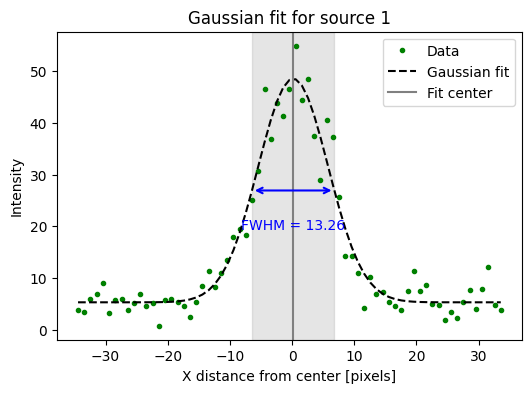

In [1098]:
fit_params, ax = plot_x_cut_gaussian(image_clean_bg, source, sourceID = 1, factor = factor)
ax.set_title(f"Gaussian fit for source {1:d}")
amp, mu, sigma, offset = fit_params # mu 是中心, sigma 是標準差
fwhm_fit = sigma * 2.355
print("Fitted FWHM:", fwhm_fit)

/var/folders/3d/n4bksl0x4vd3k4bkr3qdbr3m0000gn/T/ipykernel_80616/1896264763.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()


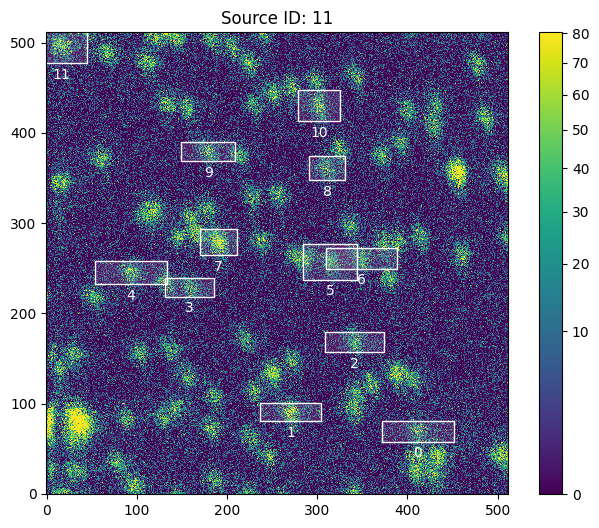

In [1099]:
import matplotlib.patches as patches

source_id = 1
fig, ax = plot_picture(image_clean_bg, percent=98.5, title='Image_12.png', figsize=(8, 6))

for i in range(len(source)):
    source_id = i
    x0, y0, x_half_range, y_half_range = source[source_id]['xcentroid'], source[source_id]['ycentroid'], 2*source[source_id]['x_fwhm'], factor*source[source_id]['y_fwhm']
    rect = patches.Rectangle(
        (x0 - x_half_range, y0 - y_half_range),  # 左下角
        2*x_half_range,  # 寬
        2*y_half_range,  # 高
        linewidth=1,
        edgecolor=(1, 1, 1, 1), # white, alpha = 1
        facecolor= (1, 1, 1, 0.1) # white, alpha = 0.3
    )
    # add text label
    ax.text(x0, y0 - y_half_range - 5, f'{source_id}', color='white', fontsize=10, ha='center', va='top')
    ax.add_patch(rect)
    ax.set_title('Source ID: {}'.format(source_id))
    fig1.show()

Source 0: Fitted FWHM: 13.741017247750095
Source 1: Fitted FWHM: 13.257163378274731
Source 2: Fitted FWHM: 13.053956610847337
Source 3: Fitted FWHM: 8.648302706161147
Source 4: Fitted FWHM: 12.35625184007859
Source 5: Fitted FWHM: 8.507137253978943
Source 6: Fitted FWHM: 6.884558593247558
Source 7: Fitted FWHM: 11.068017747220226
Source 8: Fitted FWHM: 11.707163705916537
Source 9: Fitted FWHM: 10.709532266707303
Source 10: Fitted FWHM: 11.215974589383272
Source 11: Fitted FWHM: 16.454855866670457


Text(0.5, 0.98, 'Gaussian Fits x for All Sources')

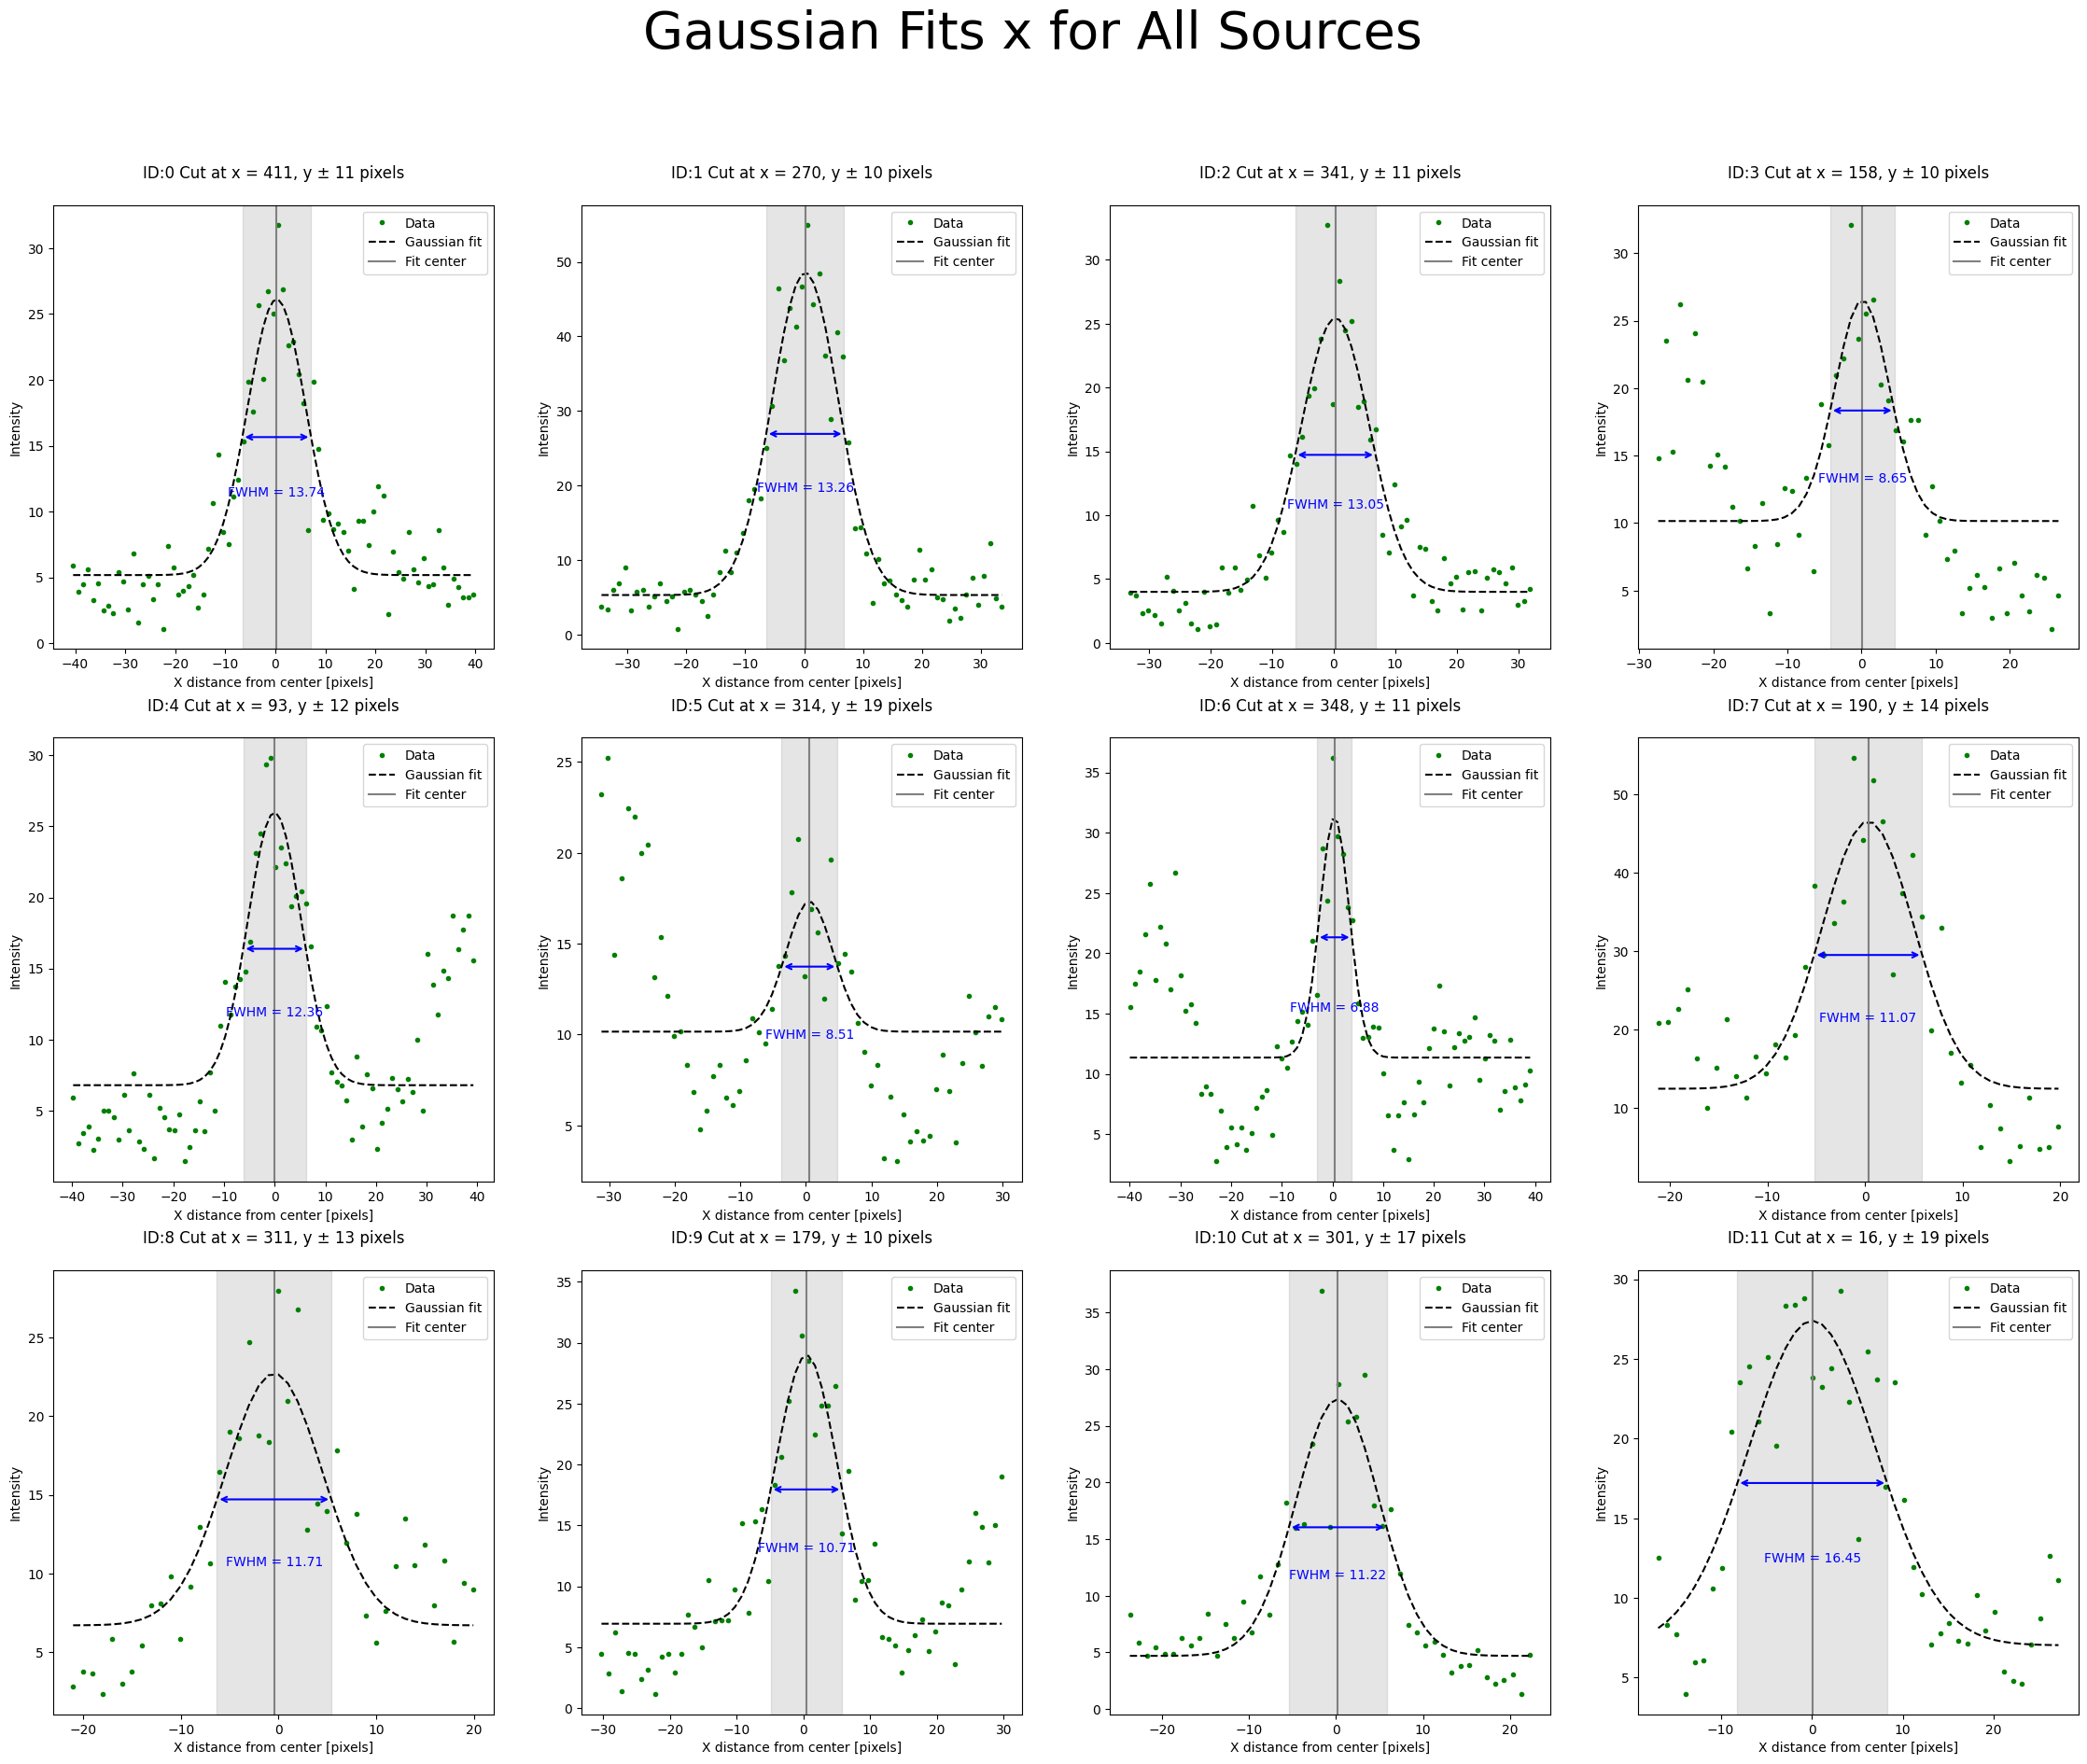

In [1100]:
# for each source, plot the x cut gaussian fit and create subplots
num_sources = len(source)

num_cols = 4
num_rows = (num_sources + num_cols - 1) // num_cols  #
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*7, num_rows*7))
axes = axes.flatten()  # 將 2D 陣列展平為
for i in range(num_sources):
    fit_params, ax = plot_x_cut_gaussian(image_clean_bg, source, sourceID = i, factor = factor, ax=axes[i])
    amp, mu, sigma, offset = fit_params # mu 是中心, sigma 是標準差
    fwhm_fit = sigma * 2.355
    print(f"Source {i}: Fitted FWHM: {fwhm_fit}")

fig.suptitle('Gaussian Fits x for All Sources', fontsize=40)

    
